In [262]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from proj1_helpers import load_csv_data
from functions import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**1. LOAD THE DATA**

In [263]:
train_set = load_csv_data('Data/train.csv', sub_sample = True)
test_set = load_csv_data('Data/test.csv', sub_sample = False)

**2. SET UP THE DATA**

x = train_set[1]
y = train_set[0]
ids = train_set[2]

x_train, x_test, y_train, y_test, ids_train, ids_test = split_data_tr_te(x, y, ids, 0.05)

In [264]:
x_train = train_set[1]
y_train = train_set[0]
ids_train = train_set[2]

x_test = test_set[1]
y_test = test_set[0]
ids_test = test_set[2]

In [265]:
na_indices = get_na_columns(x_train, 0.7, -999)

In [266]:
na_indices

[4, 5, 6, 12, 26, 27, 28]

In [267]:
x_train_clean = np.delete(x_train, na_indices, axis = 1)

In [268]:
x_test_clean= np.delete(x_test, na_indices, axis = 1)

In [269]:
na_indices_rem = get_na_columns(x_train_clean, 0, -999)

In [270]:
na_indices_rem

[0, 19, 20, 21]

In [271]:
x_train_clean_2, w_train = predict_na_columns(x_train_clean, na_indices_rem)
x_test_clean_2 = set_predict_na_columns(x_test_clean, w_train, na_indices_rem)

In [272]:
x_train_std, x_test_std = standardize(x_train_clean_2, x_test_clean_2)
x_train_std_int = np.column_stack((np.ones(x_train_std.shape[0]), x_train_std))
x_test_std_int = np.column_stack((np.ones(x_test_std.shape[0]), x_test_std))

**3. CLEAN THE DATA**

**3. DEFINE THE FUNCTIONS**

In [273]:
def least_squares(y, tx):
    A = tx.T@tx
    b = tx.T@y
    w = np.linalg.solve(A, b)
    loss = compute_mse(y, tx, w)
    return w, loss

In [274]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    ws = [initial_w]
    w = initial_w
    for n_iter in range(max_iters):
        gradient = compute_gradient_least_square(y, tx, w)
        loss = compute_mse(y, tx, w)
        w = w - gamma*gradient
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return w, loss

In [275]:
def least_squares_SGD(y, tx, initial_w, max_iters, gamma):
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):    
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            gradient = compute_stoch_gradient(minibatch_y, minibatch_tx, w)
            loss = compute_mse(minibatch_y, minibatch_tx, w)
            new_w = w - gamma*gradient
            w = new_w
            ws.append(w)
            losses.append(loss)
            print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
            bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return ws, losses

In [276]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    aI = lamb * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    w = np.linalg.solve(a, b)
    loss = compute_mse(y, tx, w)
    return w, loss

In [277]:
def logistic_regression(y, tx, initial_w, max_iters, gamma):
    loss, w = gradient_descent_log_reg(y, tx, initial_w, max_iters, gamma)
    return w, loss

In [278]:
def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    loss, w = reg_gradient_descent_log_reg(y, tx, lambda_, initial_w, max_iters, gamma)
    return w, loss

**4.CROSS VALIDATION VIZUALIZATION**

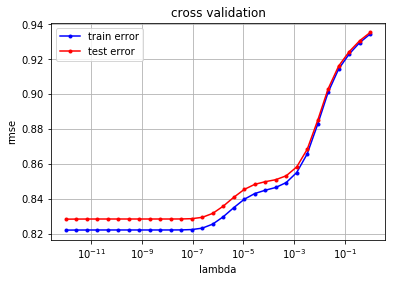

In [279]:
cross_validation_demo(y_train, x_train_std_int, 1)

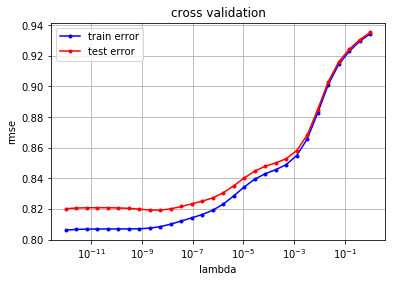

In [280]:
cross_validation_demo(y_train, x_train_std_int, 2)

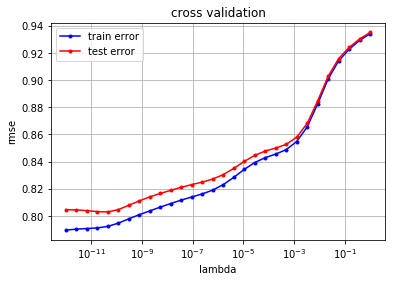

In [281]:
cross_validation_demo(y_train, x_train_std_int, 3)

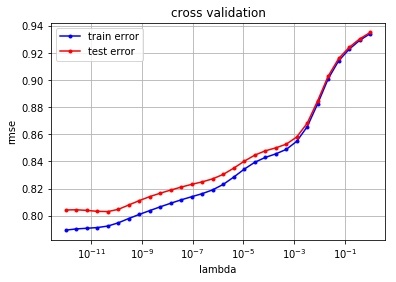

In [282]:
cross_validation_demo(y_train, x_train_std_int, 4)

**4. GET THE MODEL**

In [283]:
x_train_3 = build_poly(x_train_std_int, degree = 3)

In [284]:
w, loss = ridge_regression(y_train, x_train_3, 10**(-11))

In [285]:
x_test_3 = build_poly(x_test_std_int, degree = 3)

In [286]:
y_pr = np.around(sigmoid(x_test_3@w)).astype(int)
y_pred = zero_to_neg(y_pr).astype(int)

In [287]:
test = np.column_stack((ids_test, y_test)).astype(int)
pred = np.column_stack((ids_test, y_pred))

test = test[test[:, 0].argsort()]
pred = pred[pred[:, 0].argsort()]

In [288]:
def test_pred(y_test, y_pred):
    sum_id = np.sum(np.abs(y_test[:, 0] - y_pred[:, 0]))
    acc = 1 - np.sum(np.abs(y_test[:, 1] - y_pred[:, 1])) / y_test.shape[0] * 0.5
    return sum_id, acc

In [289]:
sum_id, acc = test_pred(test, pred)

In [290]:
sum_id, acc, len(test)

(0, 0.30808745631231982, 568238)

In [292]:
np.savetxt('Data/Final/pred_step_2.csv', pred, fmt='%i', delimiter=',', header= "Id,Prediction", comments='')

s = np.column_stack((ids_test, y_pred))

s_df = pd.DataFrame(s)
s_df.columns = ['Id', 'Prediction']

len(s_df)

s_df.to_csv('Data/23_submit_prediction_rid_reg_deg_3_10-8_clean_clean.csv', index=False)